In [8]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from collections.abc import Generator    #Abstract Base Classes for Containers (för kurviga scratches)
import cv2 as cv            #(för kurviga scratches)
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [9]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PairedImageDataset(Dataset):
    def __init__(self, root_dir_1, root_dir_2, transform=None):
        self.root_dir_1 = root_dir_1
        self.root_dir_2 = root_dir_2
        self.transform = transform
        self.image_files_1 = sorted(os.listdir(root_dir_1))
        self.image_files_2 = sorted(os.listdir(root_dir_2))
        print(len(self.image_files_1))
        print(len(self.image_files_2))
        assert len(self.image_files_1) == len(self.image_files_2), "Number of images in both directories must be the same"

    def __len__(self):
        return len(self.image_files_1)

    def __getitem__(self, idx):
        img1_name = os.path.join(self.root_dir_1, self.image_files_1[idx])
        img2_name = os.path.join(self.root_dir_2, self.image_files_2[idx])
        
        img1 = Image.open(img1_name)
        img2 = Image.open(img2_name)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to the desired size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create an instance of the dataset
dataset = PairedImageDataset(root_dir_1=r'test_real', root_dir_2=r'test_real', transform=transform)

# Create a DataLoader to iterate over the dataset in batches
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


8
8


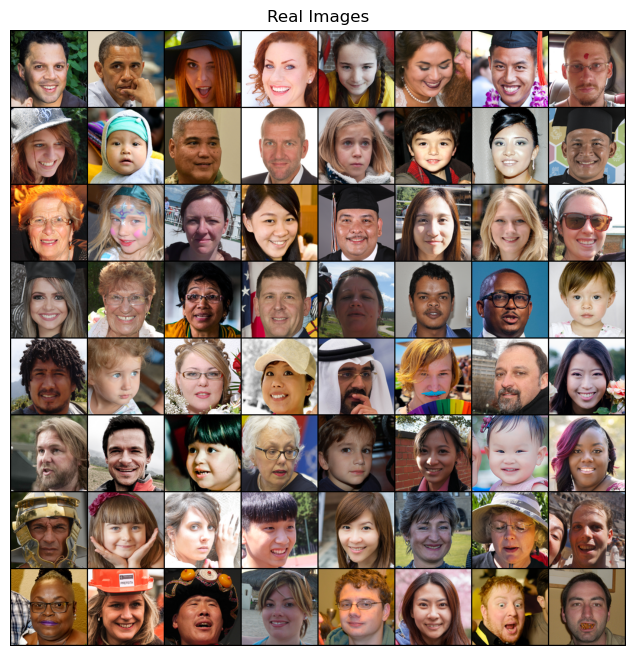

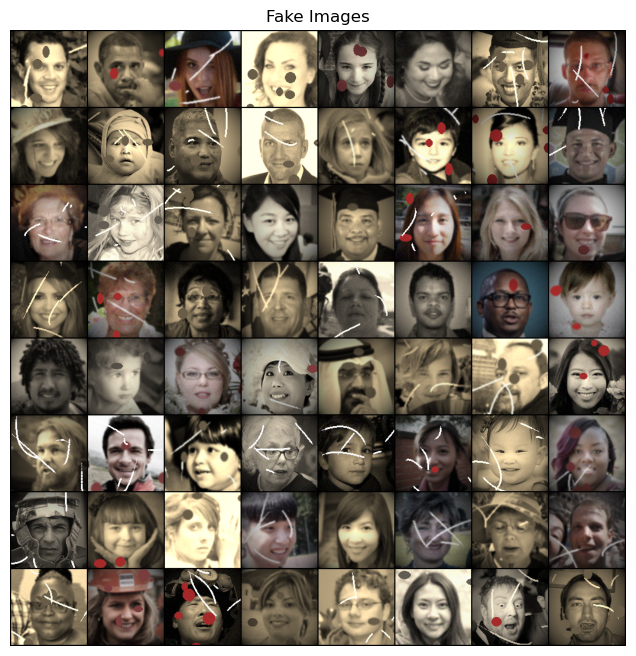

In [97]:
real_batch, fake_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:

netD = torch.load(r"network\discriminator_scripted.pt", map_location=torch.device('cpu'))
netG = torch.load(r"network\generator_scripted.pt", map_location=torch.device('cpu'))
# netG.apply(weights_init)
# netD.apply(weights_init)
print(netG)
print(netD)

RecursiveScriptModule(
  original_name=Generator
  (encoder1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (encoder2): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (encoder3): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original

c:\repo\TIF360-Project\.venv\Lib\site-packages\torch\serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [25]:
# Initialize the ``BCELoss`` function
lr = 0.0002
beta1 = 0.5
criterion = nn.BCELoss()
img_criterion = nn.L1Loss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
real, fake = next(iter(dataloader))
fixed_faces = fake
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [27]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
img_losses = []
iters = 0
num_epochs = 1
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        real_image, fake_image = data
        
        # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = real_image
        fake_cpu = fake_image
        #real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        fake = netG(fake_image)
    
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        
        # (2) Update Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)

        lossImg = img_criterion(fake,real_cpu) * 10

        lossG = errG + lossImg
        # Calculate gradients for G
        lossG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_img:%.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),lossImg.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        img_losses.append(lossImg.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_faces).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        

Starting Training Loop...


ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([6291456])) is deprecated. Please ensure they have the same size.

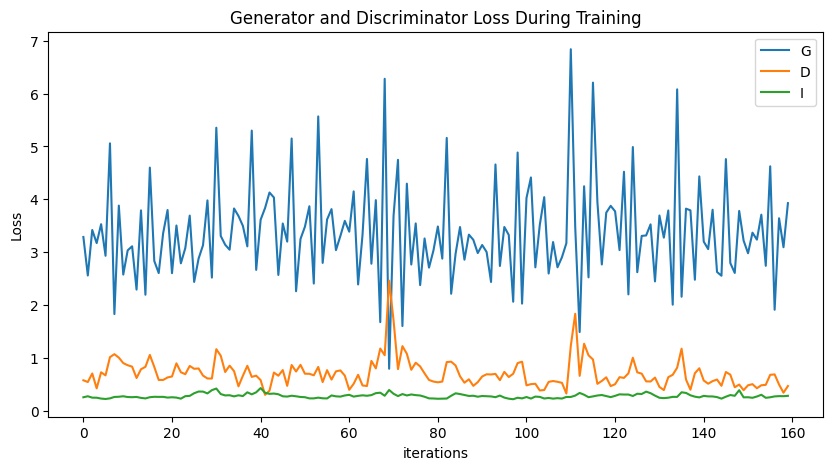

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(img_losses,label="I")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19802508..1.4505893].


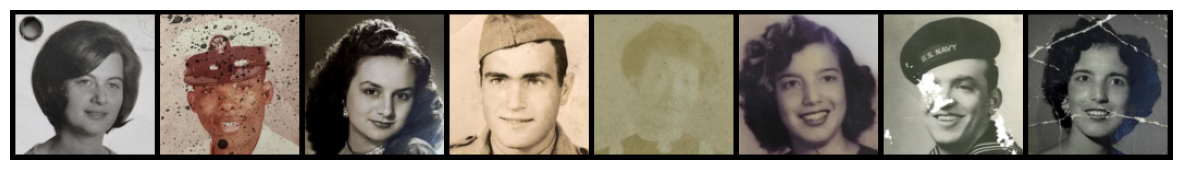

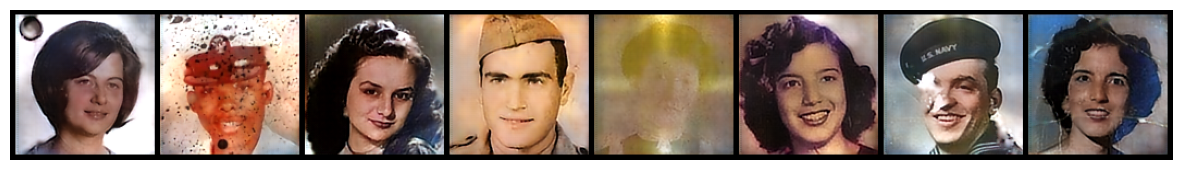

In [11]:
real_batch,fake_batch = next(iter(dataloader))
fake = netG(fake_batch)
img  = fake.detach()
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Assuming you have already defined real_batch, fake_batch, and img

# Plot and save fake images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(fake_batch[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.savefig("fake_images.png",bbox_inches='tight', pad_inches=0)  # Saving the fake images grid as an image

# # Plot and save real images
# plt.figure(figsize=(15,15))
# plt.axis("off")

# plt.imshow(np.transpose(vutils.make_grid(real_batch[:16], padding=5, normalize=True).cpu(),(1,2,0)))
# plt.savefig("real_images.png",bbox_inches='tight', pad_inches=0)  # Saving the real images grid as an image

# Plot and save generated images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(img[:32], padding=5).cpu(),(1,2,0)))
plt.savefig("generated_images.png",bbox_inches='tight', pad_inches=0)  # Saving the generated images grid as an image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


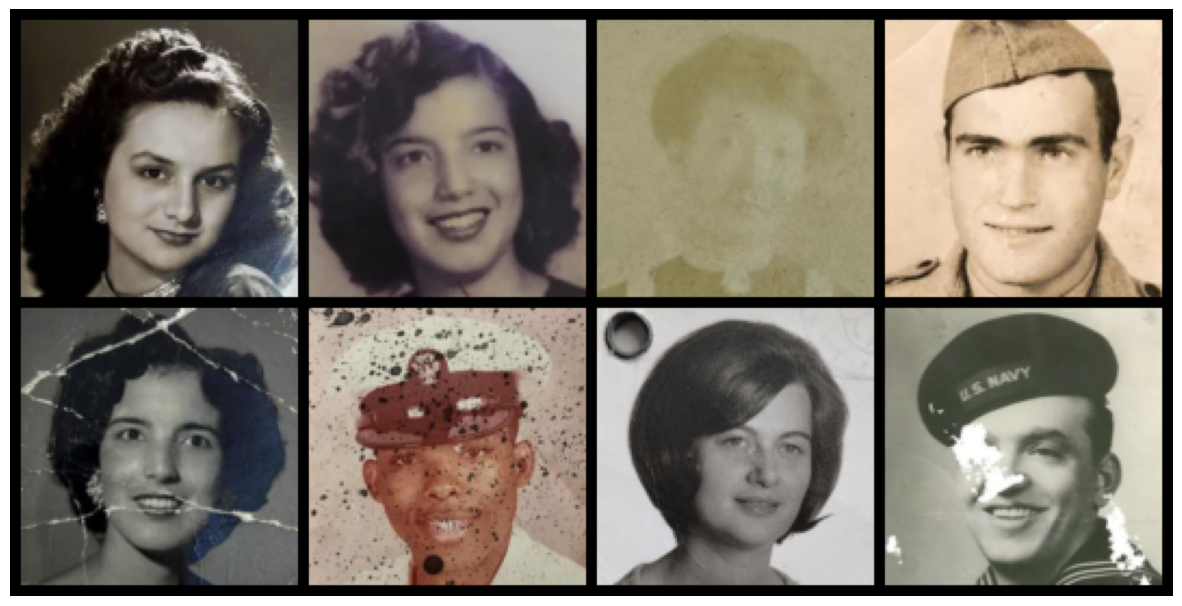

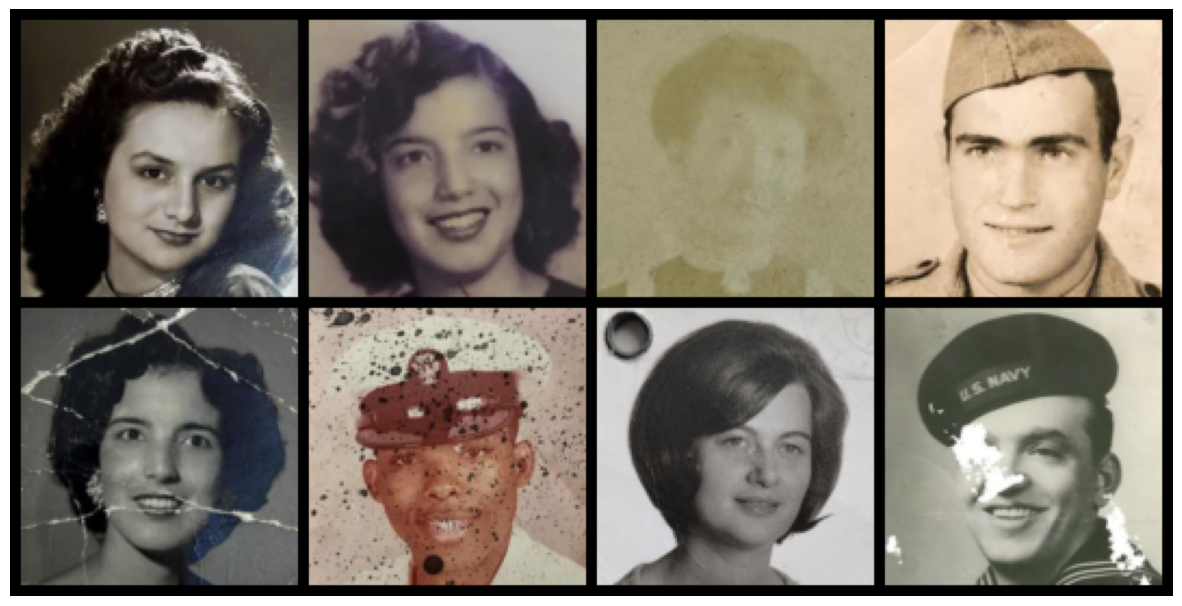

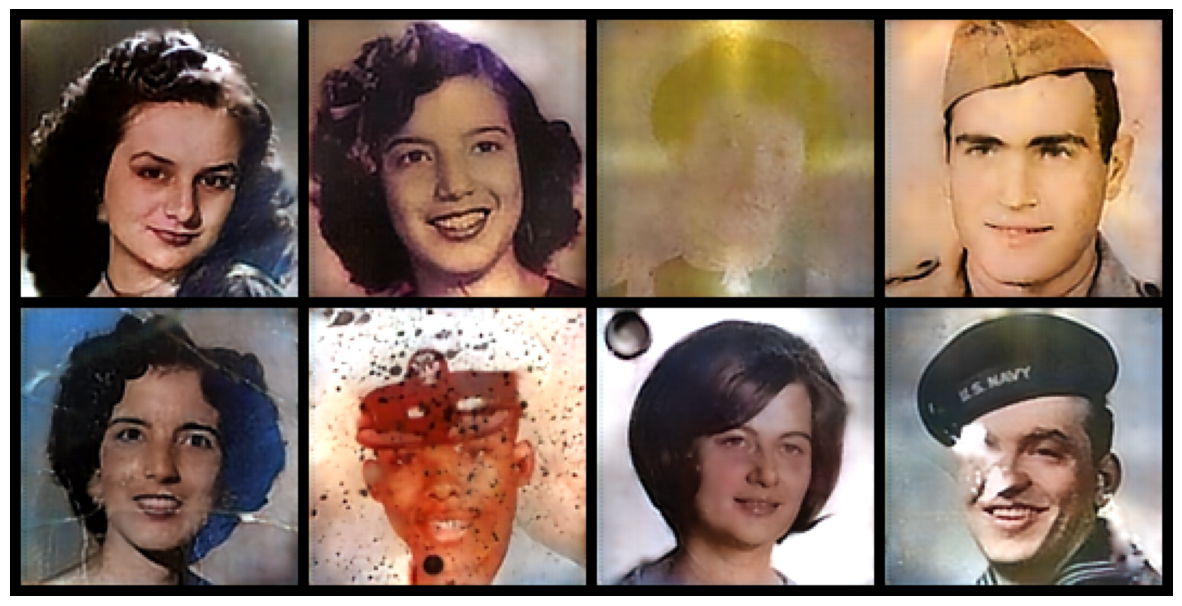

In [6]:
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(fake_batch[:8], padding=5,nrow=4, normalize=True).cpu(),(1,2,0)))
plt.savefig("fake_images.png",bbox_inches='tight', pad_inches=0)  # Saving the fake images grid as an image

# # Plot and save real images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(real_batch[:8], padding=5,nrow=4, normalize=True).cpu(),(1,2,0)))
plt.savefig("real_images.png",bbox_inches='tight', pad_inches=0)  # Saving the real images grid as an image

# Plot and save generated images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(img[:8], padding=5,nrow=4).cpu(),(1,2,0)))
plt.savefig("generated_images.png", bbox_inches='tight', pad_inches=0)  # Saving the generated images grid as an image

SSIM Loss: 0.15769648551940918


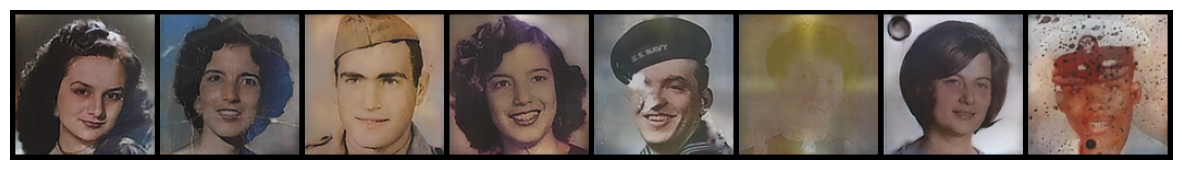

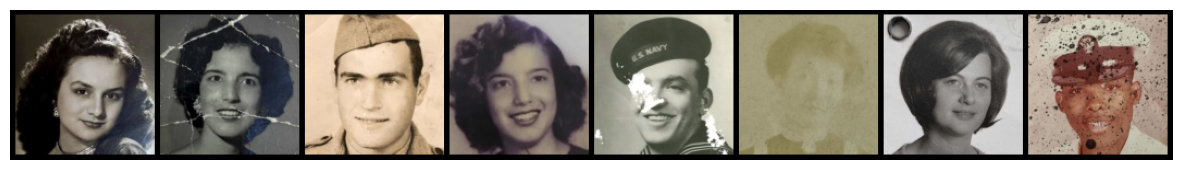

In [25]:
import torch
import piq

# Example function to ensure the image range is [0, 255]
def ensure_range(tensor, min_val=0.0, max_val=1.0, target_min=0.0, target_max=255.0):
    tensor = (tensor - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    tensor = tensor * (target_max - target_min) + target_min  # Scale to [0, 255]
    return tensor

# Assuming 'dataloader' yields batches with images in the range [-1, 1] or [0, 1]
real_batch, fake_batch = next(iter(dataloader))
fake = netG(fake_batch)

# Ensure the images are in the range [0, 255]
fake = ensure_range(fake, min_val=fake.min().item(), max_val=fake.max().item())
real_batch = ensure_range(real_batch, min_val=real_batch.min().item(), max_val=real_batch.max().item())
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(fake[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(real_batch[:32], padding=5, normalize=True).cpu(),(1,2,0)))
# Initialize the SSIM loss object
ssim_loss = piq.SSIMLoss(data_range=255.0)

# Compute SSIM loss
ssim_value = ssim_loss(fake, real_batch)
print(f'SSIM Loss: {ssim_value.item()}')